[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jrkasprzyk/CVEN5393/blob/main/lp-squandering-resources-Zeleny-1981.ipynb)

*This notebook is part of course notes for CVEN 5393: Water Resource Systems and Management, by Prof. Joseph Kasprzyk at CU Boulder.*

This notebook implements the experiments in Zeleny (1981):

Zeleny, M (1981) "On the Squandering of Resources and Profits via Linear Programming" *Interfaces* 11(5): 101-107. [JSTOR link](http://www.jstor.org/stable/25060153?origin=JSTOR-pdf)



# Object-Oriented Code for Product Mix Profit Maximization

The below code is an object-oriented framework for solving linear programs (LP), specifically of the type **product mix profit maximization**. A company needs to decide how much of multiple *products* to make, which share *resources*. The object oriented code has `Resource`, `Product`, and `ProductMixProblem` classes.

The framework is helpful here, because we will want to quickly create multiple versions of the LP, and this will be much easier to manipulate relative to manually updating matricies of coefficients.

In [ ]:
from typing_extensions import Self
from scipy.optimize import linprog
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import copy

# Define a list of RGB tuples (Colorbrewer Dark2) used later in the plots
colors = [(27, 158, 119), (217, 95, 2), (117, 112, 179), (231, 41, 138), (102, 166, 30), (230, 171, 2), (166, 118, 29), (102, 102, 102)]
colors = [(r/255, g/255, b/255) for r,g,b in colors]

class Resource:
  def __init__(self, name, total_amount, unit_price = None, amount_used=0):
    self.name = name
    self.total_amount = total_amount
    self.unit_price = unit_price
    self.amount_used = amount_used

class Product:
  def __init__(self, name, net_profit, amount=None):
    self.name = name
    self.net_profit = net_profit
    self.amount = amount
    self.requirements = {}
  def add_requirement(self, name, unit_requirement):
    self.requirements.update({name: unit_requirement})
  def add_amount(self, amount):
    self.amount = amount

class ProductMixProblem:
  def __init__(self, notes=None):
    self.is_solved = False
    self.products = []
    self.resources = []
    self.notes = notes
  def add_product(self, name, net_profit):
    self.is_solved = False
    self.products.append(Product(name, net_profit))
  def add_resource(self, name, total_amount, unit_price=None):
    self.is_solved = False
    self.resources.append(Resource(name, total_amount, unit_price))
  def add_requirement_to_product(self, product_name, resource_name, unit_requirement):
    # the user can add a requirement to a product in any order. So we have to find
    # which product they're working on now
    self.is_solved = False
    for product in self.products:
      if product.name == product_name:
        product.add_requirement(resource_name, unit_requirement)
        return #don't need to continue searching once we've matched the product
  def add_amount_to_product(self, product_name, amount):
    # the user can add a requirement to a product in any order. So we have to find
    # which product they're working on now
    self.is_solved = False
    for product in self.products:
      if product.name == product_name:
        product.add_amount(amount)
        return #don't need to continue searching once we've matched the product
  
  def modify_net_profit(self, product_name, net_profit):
    self.is_solved = False
    for product in self.products:
      if product.name == product_name:
        product.net_profit = net_profit
        return #don't need to continue searching once we've matched the product    
  def modify_total_amount(self, resource_name, total_amount):
    self.is_solved = False
    for resource in self.resources:
      if resource.name == resource_name:
        resource.total_amount = total_amount
        return #don't need to continue searching once we've matched the product
  def calc_total_profit(self):
    self.total_profit = 0
    for product in self.products:
      self.total_profit = self.total_profit + product.net_profit*product.amount
  def calc_total_resource_cost(self):
    self.total_resource_cost = 0
    for resource in self.resources:
      self.total_resource_cost = self.total_resource_cost + resource.unit_price*resource.total_amount
  def calc_resource_usage(self):
    
    for resource in self.resources:
      resource.amount_used = 0
      for product in self.products:
          if product.requirements.get(resource.name):
            resource.amount_used += product.amount*product.requirements[resource.name]

  def solve(self):
    self.num_products = len(self.products)
    self.num_resources = len(self.resources)
      
    self.c = np.zeros(self.num_products)
    self.A = np.zeros((self.num_resources, self.num_products))

    for i, product in enumerate(self.products):

      # the objective function coefficients are the net profits of each source.
      # because linprog expects minimize, and we want to maximize, multiply by -1
      self.c[i] = -1*product.net_profit

      for j, resource in enumerate(self.resources):
        # if product i requires the jth resource...
        if product.requirements.get(resource.name):
          self.A[j, i] = product.requirements[resource.name]
        else:
          # otherwise make sure there's a 0 coefficient
          self.A[j, i] = 0.0
        
    self.b = [resource.total_amount for resource in self.resources]
    self.bounds = [(0, None) for product in self.products]

    # solve LP
    self.opt_results = linprog(self.c, A_ub=self.A, b_ub=self.b, bounds=self.bounds)
   
    if self.opt_results.success == True:
      self.is_solved = True
      for i, product in enumerate(self.products):
        product.amount = self.opt_results.x[i]
      for i, resource in enumerate(self.resources):
        # calculate amount used of resources
        resource.shadow_price = -1*self.opt_results.ineqlin.marginals[i]
      self.total_profit = -1*self.opt_results.fun    
    else:
      message = [
          f"Optimization results returned flag:\n",
          f"{self.opt_results.success}\n",
          f"Please investigate by viewing [your class instance].opt_results."
      ]
      print(*message)
    
    # calculate extra helper variables that summarize results
    self.calc_resource_usage()
    self.calc_total_resource_cost()
  def calc_manual_solution(self):
    # for manually adding amounts to products and finding the answer
    self.calc_total_resource_cost()
    self.calc_resource_usage()
    self.calc_total_profit()
  def get_opt_results(self):
    if (self.opt_results.success == True) & (self.is_solved == True):
      opt_products = {}
      for product in self.products:
        opt_products.update({product.name: product.amount})
      return self.total_profit, opt_products
    else:
      print(f"Error! Houston we have a problem. is_solved is {self.is_solved} and opt_results.success = {self.opt_results.success}. Please investigate.")
      
  def display_feasible_region(self, sq_lb, sq_ub, show_optimal=False, show_level_curves=False):

    if self.num_products == 2:

      # initiate plot
      plt.figure(dpi=150)

      # create mesh to draw the feasible region
      d = np.linspace(sq_lb, sq_ub, 300)
      self.x1_grid, self.x2_grid = np.meshgrid(d,d)

      # determine if a point in the grid is feasible and plot
      # (the point is only feasible if it obeys ALL constraints)
      is_it_in = True
      for i in range(self.num_resources):
        is_it_in = is_it_in & ((self.A[i,0]*self.x1_grid + self.A[i,1]*self.x2_grid) <= self.b[i])
      plt.imshow( is_it_in.astype(int),
                  extent = (
                      self.x1_grid.min(),
                      self.x1_grid.max(),
                      self.x2_grid.min(),
                      self.x2_grid.max()
                  ),
                  origin= "lower",
                  cmap= "Greys",
                  alpha = 0.3
        )
      
      # show constraint bounding lines (one for each resource)
      self.x1_vals_for_lines = np.linspace(sq_lb, sq_ub, 300)
      self.x2_vals_for_lines = np.zeros((self.num_resources, len(self.x1_vals_for_lines)))
      color_iterator = cycle(colors)
      for i, resource in enumerate(self.resources):
        color = next(color_iterator)
        if self.A[i, 1] == 0:
            x1_val = self.b[i] / self.A[i, 0]
            plt.vlines(x1_val,
                       ymin=sq_lb,
                       ymax=sq_ub,
                       label=resource.name,
                       color=color)
        else:
            self.x2_vals_for_lines[i, :] = (self.b[i] - self.A[i,0]*self.x1_vals_for_lines) / self.A[i,1]
            plt.plot(self.x1_vals_for_lines, 
                     self.x2_vals_for_lines[i, :],
                     label=resource.name,
                     color=color
                    )
            
      # show level curves
      if (show_level_curves == True):
        show_Z_vals = True #plots text of the Z levels
        self.x1_vals_for_curves = np.linspace(sq_lb, sq_ub, 300)

        num_Z = 5 #the number of levels of Z to show
        Z_vals = np.linspace(0, self.total_profit, num_Z)
        self.x2_vals_for_curves = np.zeros((num_Z, len(self.x1_vals_for_curves)))

        if self.c[1] == 0:
          print("error! coefficient on x2 is 0, thus cannot plot lines")
        else:
          for i, Z in enumerate(Z_vals):
            self.x2_vals_for_curves[i, :] = (Z -
                                             self.products[0].net_profit*self.x1_vals_for_curves) / self.products[1].net_profit
            plt.plot(self.x1_vals_for_curves, 
                     self.x2_vals_for_curves[i, :],
                     linestyle="--",
                     color='black'
                        )
            if show_Z_vals == True:
              plt.text(Z_vals[i]/self.products[0].net_profit,
                    sq_lb+0.2,
                    f"{Z_vals[i]: 0.1f}",
                    fontsize=6) 

        # make a marker at the optimal solution        
        if (show_optimal == True):
          plt.scatter(self.products[0].amount,
                      self.products[1].amount,
                      s=100,
                      c='black'
                      )
          plt.text(self.products[0].amount + 0.2,
                  self.products[1].amount + 0.2,
                  f"{self.products[0].amount: 0.1f}, {self.products[1].amount: 0.1f}, Z={self.total_profit: 0.1f}",
                  fontsize=12)
      
      plt.ylim(sq_lb, sq_ub)
      plt.xlabel(self.products[0].name)
      plt.ylabel(self.products[1].name)
      
      # we have confused things by plotting more lines than we have
      # resources. So here, we only plot the legend for the number
      # of resources we have:      
      handles, labels = plt.gca().get_legend_handles_labels()
      new_handles = handles[:self.num_resources]
      new_labels = labels[:self.num_resources]
      plt.legend(new_handles, new_labels,
                 loc="lower left",
                 bbox_to_anchor=(0, 1, 1, 0),
                 mode="expand",
                 ) 

    else:
      print("This function is only set up for the case where there are two products!")
  def display_opt_results(self):
    message = [
        f"Product: Amount\n"] + \
        [f"{product.name}: {product.amount: 0.1f}\n" for product in self.products] + \
        [f"---\n",
        f"Profit: {self.total_profit}\n",
        f"---\n"
        ]
    print(*message)
  def display_shadow_prices(self):
    message = [
        f"Product - Total Amount - Shadow Price\n"] + \
        [f"{resource.name} - {resource.total_amount: 0.1f} - {resource.shadow_price: 0.1f}\n" for resource in self.resources]
    print(*message)



# Implementation

The object `problem` will contain the original data from Zeleny (1981). Then we will create copies of the problem that reproduce the different 'Acts' in the paper where the author talks about different methods of solving the problem.

In [ ]:
problem = ProductMixProblem()
problem.add_resource(name="Golden Thread", total_amount=20, unit_price = 30)
problem.add_resource("Silk", 24, 40)
problem.add_resource("Velvet", 60, 9.5)
problem.add_resource("Silver Thread", 10.5, 20)
problem.add_resource("Nylon", 26, 10)
problem.add_product("Product X", 400)
problem.add_product("Product Y", 300)
problem.add_requirement_to_product("Product X", "Golden Thread", 4)
problem.add_requirement_to_product("Product X", "Silk", 2)
problem.add_requirement_to_product("Product X", "Velvet", 12)
problem.add_requirement_to_product("Product X", "Nylon", 4)
problem.add_requirement_to_product("Product Y", "Silver Thread", 3)
problem.add_requirement_to_product("Product Y", "Silk", 6)
problem.add_requirement_to_product("Product Y", "Velvet", 4)
problem.add_requirement_to_product("Product Y", "Nylon", 4)


In [ ]:
formulations = []

# Initial Manual Solution

In [ ]:
formulations.append(copy.deepcopy(problem))
formulation = formulations[-1]
formulation.notes = "Manual: Make most x since it's most profitable"
formulation.calc_total_resource_cost()
formulation.add_amount_to_product("Product X", 5)
formulation.add_amount_to_product("Product Y", 0)
formulation.is_solved = True
formulation.calc_manual_solution()
formulation.display_opt_results()

Product: Amount
 Product X:  5.0
 Product Y:  0.0
 ---
 Profit: 2000
 ---



# Act 1: Manual solution

In [ ]:
formulations.append(copy.deepcopy(problem))
formulation = formulations[-1]
formulation.notes = "Manual: Make most x use all silk"
formulation.calc_total_resource_cost()
formulation.add_amount_to_product("Product X", 3.75)
formulation.add_amount_to_product("Product Y", 2.75)
formulation.is_solved = True
formulation.calc_total_profit()
formulation.display_opt_results()

Product: Amount
 Product X:  3.8
 Product Y:  2.8
 ---
 Profit: 2325.0
 ---



# Act 2: Solve as LP

Product: Amount
 Product X:  4.2
 Product Y:  2.2
 ---
 Profit: 2375.0
 ---



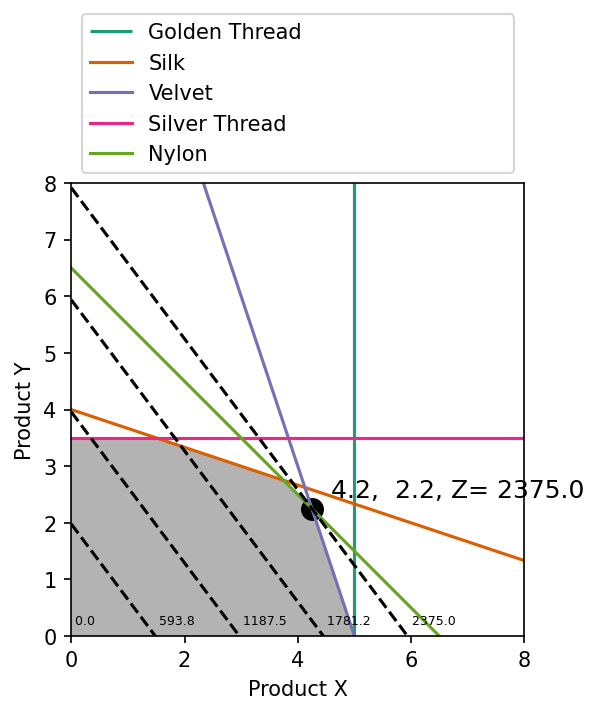

In [ ]:
formulations.append(copy.deepcopy(problem))
formulation = formulations[-1]
formulation.notes = "Initial LP"
formulation.solve()
formulation.display_opt_results()
formulation.display_feasible_region(0, 8, show_optimal=True, show_level_curves=True)

# Act 3: Modify Resource Availability


Product: Amount
 Product X:  4.1
 Product Y:  2.6
 ---
 Profit: 2437.5
 ---



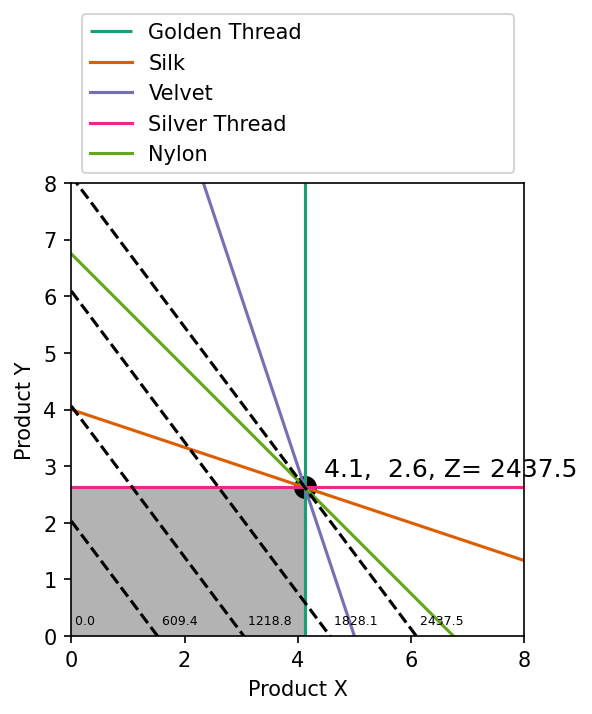

In [ ]:
formulations.append(copy.deepcopy(problem))
formulation = formulations[-1]
formulation.notes = "LP with modified resources"
formulation.modify_total_amount("Golden Thread", 16.5)
formulation.modify_total_amount("Silver Thread", 7.875)
formulation.modify_total_amount("Nylon", 27)

formulation.solve()
formulation.display_opt_results()
formulation.display_feasible_region(0, 8, show_optimal=True, show_level_curves=True)

# Act 4

Product: Amount
 Product X:  4.1
 Product Y:  2.8
 ---
 Profit: 2468.75
 ---



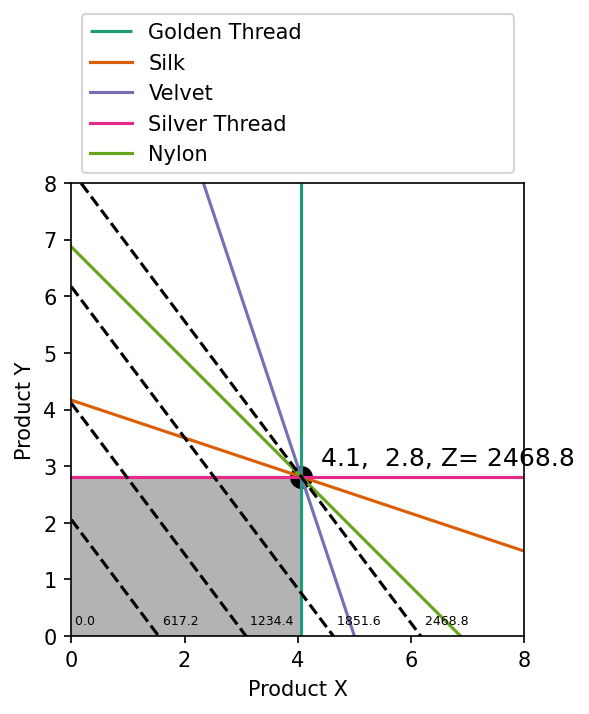

In [ ]:
formulations.append(copy.deepcopy(problem))
formulation = formulations[-1]
formulation.notes = "LP with further modified resources"
formulation.modify_total_amount("Golden Thread", 16.25)
formulation.modify_total_amount("Silk", 25)
formulation.modify_total_amount("Velvet", 60)
formulation.modify_total_amount("Silver Thread", 8.4375)
formulation.modify_total_amount("Nylon", 27.5)

formulation.solve()
formulation.display_opt_results()
formulation.display_feasible_region(0, 8, show_optimal=True, show_level_curves=True)

# Act 5

Product: Amount
 Product X:  7.3
 Product Y: -0.0
 ---
 Profit: 2933.333333333333
 ---



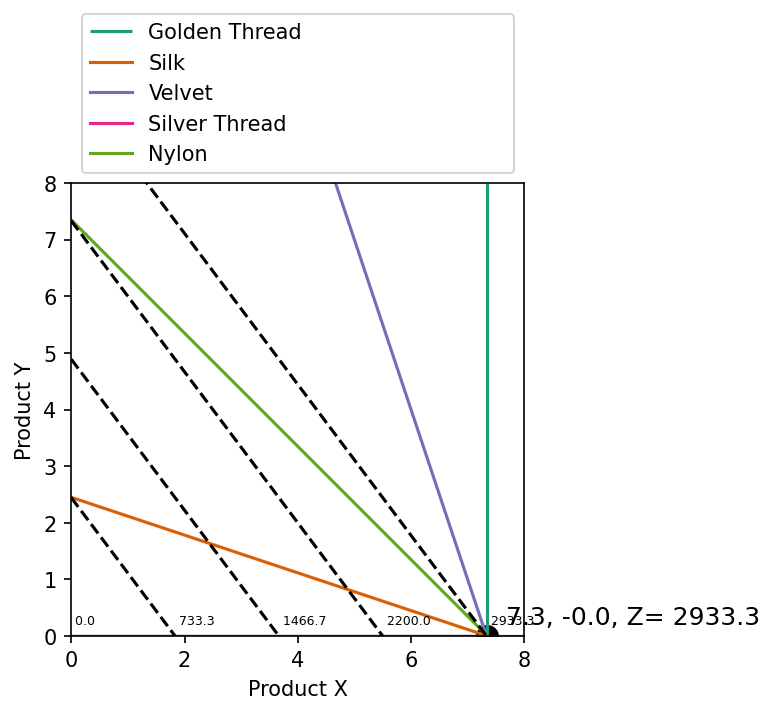

In [ ]:
formulations.append(copy.deepcopy(problem))
formulation = formulations[-1]
formulation.notes = "LP - use all resources"
formulation.modify_total_amount("Golden Thread", 29.4)
formulation.modify_total_amount("Silk", 14.7)
formulation.modify_total_amount("Velvet", 88)
formulation.modify_total_amount("Silver Thread", 0)
formulation.modify_total_amount("Nylon", 29.4)

formulation.solve()
formulation.display_opt_results()
formulation.display_feasible_region(0, 8, show_optimal=True, show_level_curves=True)

# Summarize

In [ ]:
import pandas as pd

df = pd.DataFrame(
    columns = ["Trial"] +
    [product.name for product in problem.products] +
    [resource.name for resource in problem.resources] +
    ["Total Resource Cost", "Total Profit"]
)

df["Trial"] = [i for i in range(1, len(formulations)+1)]

for i, formulation in enumerate(formulations):
  for product in formulation.products:
    df.at[i, product.name] = product.amount
  for resource in formulation.resources:
    df.at[i, resource.name] = resource.amount_used  

df["Total Resource Cost"] = [formulation.total_resource_cost for formulation in formulations]
df["Total Profit"] = [formulation.total_profit for formulation in formulations]
df["Notes"] = [formulation.notes for formulation in formulations]


In [ ]:
df

,Trial,Product X,Product Y,Golden Thread,Silk,Velvet,Silver Thread,Nylon,Total Resource Cost,Total Profit,Notes
0,1,5,0,20,10,60,0,20,2600.00,2000.000000,Manual: Make most x since it's most profitable
1,2,3.75,2.75,0,0,0,0,0,2600.00,2325.000000,Manual: Make most x use all silk
2,3,4.25,2.25,17.0,22.0,60.0,6.75,26.0,2600.00,2375.000000,Initial LP
3,4,4.125,2.625,16.5,24.0,60.0,7.875,27.0,2452.50,2437.500000,LP with modified resources
4,5,4.0625,2.8125,16.25,25.0,60.0,8.4375,27.5,2501.25,2468.750000,LP with further modified resources
5,6,7.333333,-0.0,29.333333,14.666667,88.0,0.0,29.333333,2600.00,2933.333333,LP - use all resources
